# Desafio 5 - Escola DNC

# Contexto

Empresa de e-commerce necessita do levantamento de indicadores de recência, frequência e ticket médio (RFM) dos clientes. Lhes foi enviado uma grande base de dados e o resultado final será um **dataset apenas com a identificação do cliente e métricas RFM**.

# Definição de RFM

RFM é um modelo de classificação de clientes baseado em 3 fatores:

- **R (recency):** tempo que o cliente realizou a última compra (em dias);
- **F (Frequency):** quantidade de compras realizadas pelo cliente;
- **M (Monetary):** valor do ticket médio gasto pelo cliente;

# Metadados

| Variables | Description |
| --- | --- |
| CustomerID | Código de identificação do cliente |
| Description | Descrição do produto |
| InvoiceNo | Código da fatura |
| StockCode | Código de estoque do produto |
| Quantity | Quantidade do produto |
| InvoiceDate | Data do faturamento (compra) |
| UnitPrice | Preço unitário do produto|

# Leitura e Tratamento dos Dados

## Bibliotecas necessárias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OrdinalEncoder
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from skimpy import skim
import datetime

## Carregando data.frame

In [2]:
df1 = pd.read_csv('data.csv', sep = ',', encoding = 'latin1')

In [3]:
df1.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
skim(df1)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 541909 │ │ string      │ 5     │                                                          │
│ │ Number of columns │ 8      │ │ float64     │ 2     │                                                          │
│ └───────────────────┴────────┘ │ int64       │ 1     │                                                          │
│                                └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┓  │
│ ┃ column_name     ┃ NA        ┃ NA %   ┃ mean    ┃ sd     ┃ p0       ┃ p25     ┃ p75     ┃ p100    ┃ hist    ┃  │
│ ┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━┩  │
│ │ Quantity        │         0 │      0 │     9.6 │    220 │   -81000 │       1 │      10 │   81000 │     █   │  │
│ │ UnitPrice       │         0 │      0 │     4.6 │     97 │   -11000 │     1.2 │     4.1 │   39000 │    █    │  │
│ │ CustomerID      │    140000 │     25 │   15000 │   1700 │    12000 │   14000 │   17000 │   18000 │ ▇▆█▆▆▇  │  │
│ └─────────────────┴───────────┴────────┴─────────┴────────┴──────────┴─────────┴─────────┴─────────┴─────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name              ┃ NA         ┃ NA %       ┃ words per row               ┃ total words             ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ InvoiceNo                │          0 │          0 │                           1 │                  540000 │  │
│ │ StockCode                │          0 │          0 │                           1 │                  540000 │  │
│ │ Description              │       1500 │       0.27 │                           1 │                  540000 │  │
│ │ InvoiceDate              │          0 │          0 │                           1 │                  540000 │  │
│ │ Country                  │          0 │          0 │                           1 │                  540000 │  │
│ └──────────────────────────┴────────────┴────────────┴─────────────────────────────┴─────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [6]:
# CustomerID possui 25% de NA's, vamos checar

df1[df1['CustomerID'].isna()].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,12/1/2010 14:32,0.43,NaN,United Kingdom
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,12/1/2010 14:32,0.43,NaN,United Kingdom
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,12/1/2010 14:32,0.43,NaN,United Kingdom


## Criando data.frame secundário para manipulação

In [7]:
# Removendo NA's e criando novo dataset

df2 = df1.copy().dropna()

In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [9]:
df2.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [10]:
# Removendo duplicatas

df2 = df2.drop_duplicates()

In [11]:
# Removendo valores negativos em Quantity e Price

df2 = df2.query('Quantity > 0 and UnitPrice > 0')

In [12]:
# Corrigindo coluna datas e separando em novas colunas

df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'], format = '%m/%d/%Y %H:%M')

In [13]:
df2['CustomerID'] = df2['CustomerID'].astype(int)

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392692 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    392692 non-null  object        
 1   StockCode    392692 non-null  object        
 2   Description  392692 non-null  object        
 3   Quantity     392692 non-null  int64         
 4   InvoiceDate  392692 non-null  datetime64[ns]
 5   UnitPrice    392692 non-null  float64       
 6   CustomerID   392692 non-null  int64         
 7   Country      392692 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.0+ MB


In [15]:
# Removendo outliers de Quantity e UnitPrice

df2.drop(df2.query('Quantity > 10000 or UnitPrice > 5000').index, axis = 0, inplace = True)

In [17]:
# Criando coluna TotalValue

df2['TotalValue'] = df2['Quantity'] * df2['UnitPrice']

In [18]:
# data ultima compra

df2['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

# Análise de Dados

## Top 10 países com maior valor de vendas

In [19]:
paises = df2.groupby('Country')['TotalValue'].sum().reset_index().sort_values('TotalValue', ascending = False)


In [20]:
round(paises.nlargest(10, ['TotalValue']),2)

,Country,TotalValue
35,United Kingdom,7031228.69
23,Netherlands,285446.34
10,EIRE,265262.46
14,Germany,228678.40
13,France,208934.31
0,Australia,138453.81
30,Spain,61558.56
32,Switzerland,56443.95
3,Belgium,41196.34
31,Sweden,38367.83


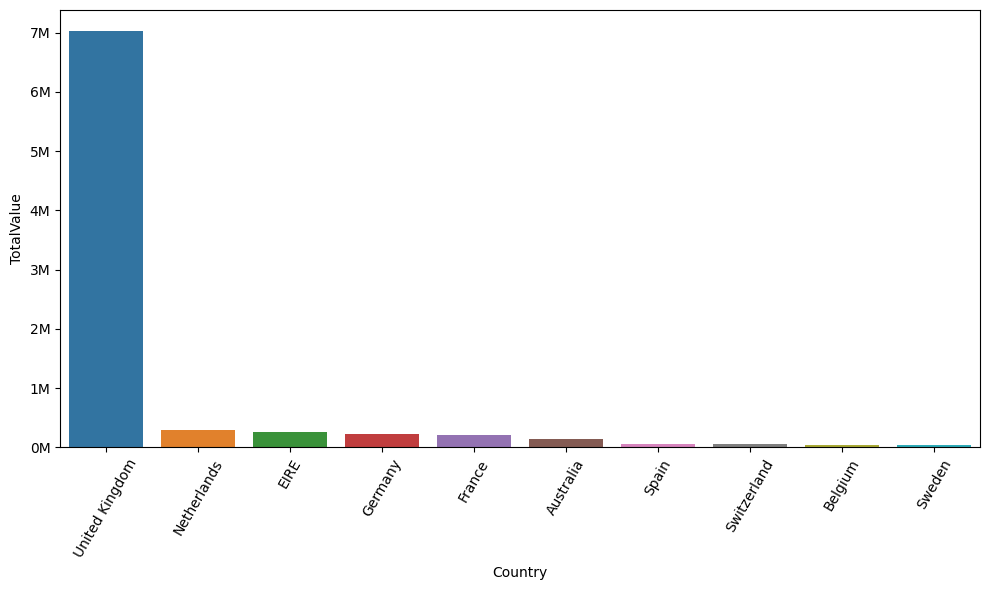

In [42]:
from matplotlib.ticker import FuncFormatter

f = lambda x, pos: f'{x/10**6:,.0f}M'


fig, ax = plt.subplots(figsize=(10, 6))    

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data = paises.nlargest(10, ['TotalValue']),
    x = 'Country', y = 'TotalValue', log = False)
plt.xticks(rotation = 60)
ax.yaxis.set_major_formatter(FuncFormatter(f))
plt.yticks(np.arange(0, 8000000, 1000000))
plt.show( )

## Top 10 produtos mais vendidos

In [45]:
produtos = df2.groupby('Description')['Quantity'].sum().sort_values(ascending = False).reset_index()

In [46]:
round(produtos.nlargest(10, ['Quantity']),2)

,Description,Quantity
0,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54319
1,JUMBO BAG RED RETROSPOT,46078
2,WHITE HANGING HEART T-LIGHT HOLDER,36706
3,ASSORTED COLOUR BIRD ORNAMENT,35263
4,PACK OF 72 RETROSPOT CAKE CASES,33670
5,POPCORN HOLDER,30919
6,RABBIT NIGHT LIGHT,27153
7,MINI PAINT SET VINTAGE,26076
8,PACK OF 12 LONDON TISSUES,25329
9,PACK OF 60 PINK PAISLEY CAKE CASES,24230


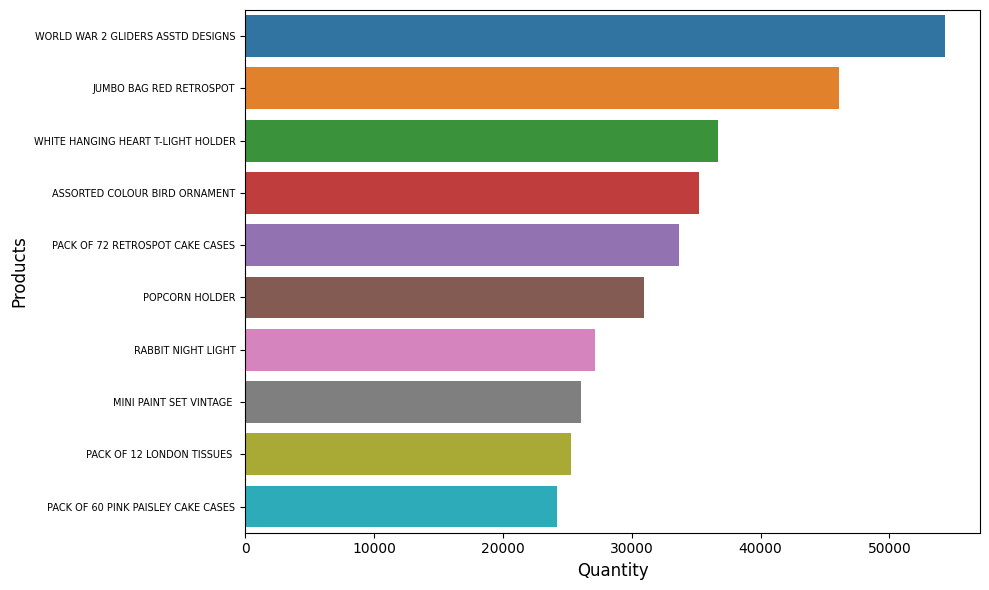

In [76]:
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True
sns.barplot(data = produtos.nlargest(10, ['Quantity']),
    y = 'Description', x = 'Quantity', log = False)
plt.ylabel('Products', size = 12)
plt.xlabel('Quantity', size = 12)
plt.tick_params(axis='y', labelsize=7)
plt.show( )

## Venda total por mês

In [96]:
df2.groupby(df2['InvoiceDate'].dt.month)['TotalValue'].sum().reset_index()

,InvoiceDate,TotalValue
0,1,490917.710
1,2,446084.920
2,3,594081.760
3,4,468374.331
4,5,669212.400
5,6,660046.050
6,7,598962.901
7,8,644051.040
8,9,950690.202
9,10,1035642.450


## Venda total por mês e país

In [47]:
top_10 = df2[df2["Country"].str.contains('United Kingdom|Netherlands|EIRE|Germany|France|Australia|Spain|Switzerland|Belgium|Sweden')]

top_10 = top_10.groupby([top_10['InvoiceDate'].dt.month, 'Country'])['TotalValue'].sum().reset_index().sort_values(['InvoiceDate', 'TotalValue'], ascending = [True, False])

In [48]:
top_10

,InvoiceDate,Country,TotalValue
9,1,United Kingdom,363692.73
5,1,Netherlands,26611.16
2,1,EIRE,21904.19
3,1,France,17740.12
4,1,Germany,16880.84
...,...,...,...
117,12,Sweden,4072.30
111,12,Belgium,3227.64
116,12,Spain,2159.94
118,12,Switzerland,1304.92


## Cálculo do RFM

In [177]:
# Agrupar os dados por cliente e pedido e obter a data e o preço total

df2_pedido = df2.groupby(['CustomerID', 'InvoiceNo']).agg({'InvoiceDate': 'max', 'TotalValue': 'sum'}).reset_index()

# Calcular a recência (R)

max_date = df2_pedido['InvoiceDate'].max()

df2_pedido['Recency'] = (max_date - df2_pedido['InvoiceDate']).dt.days

# Calcular a frequência (F)
df_frequency = df2_pedido.groupby('CustomerID')['InvoiceNo'].count().reset_index()
df_frequency.columns = ['CustomerID', 'Frequency']

# Calcular o ticket médio (M)

df_monetary = df2_pedido.groupby('CustomerID')['TotalValue'].mean().reset_index()

df_monetary.columns = ['CustomerID', 'Monetary']

# Juntar as informações de recência (R), frequência (F) e ticket médio (M)

df_rfm = df_frequency.merge(df_monetary, on='CustomerID')

df_rfm = df_rfm.merge(df2_pedido[['CustomerID', 'Recency']], on='CustomerID')

# Filter pelo valor mínimo de Recency

df_rfm.groupby(['CustomerID','Frequency','Monetary'])['Recency'].min().reset_index()

,CustomerID,Frequency,Monetary,Recency
0,12347,7,615.714286,1
1,12348,4,449.310000,74
2,12349,1,1757.550000,18
3,12350,1,334.400000,309
4,12352,8,313.255000,35
...,...,...,...,...
4332,18280,1,180.600000,277
4333,18281,1,80.820000,180
4334,18282,2,89.025000,7
4335,18283,16,127.845625,3
